# Knowledge Transfer

This is going to be a bit all over the place. I'm letting you know that from the outset, because the description in [my favourite paper](http://www.jmlr.org/papers/volume16/vapnik15b/vapnik15b.pdf) is to be honest, all over the place.

I'm hoping to use this notebook as a way of figuring it out. So let's take a look at what we're trying to do.

## 3 Steps to Knowledge Transfer

1. Find the fundamental elements of knowledge $u^*_1,\cdots ,u^*_m$ in space $X^*$.
2. Find the frames ($m$ functions) $K^*(u^*_1,x^*),\cdots ,K^*(u^*_m,x^*)$ in space $X^*$.
3. Find the functions $\phi_1(x_i),\cdots , \phi_m(x_i)$ in space $X$ so $\phi_k(x_i) \approx K^*(u^*_k,x^*_i)$ holds true for almost all pairs $(x_i,x^*_i)$

Then the plan is to use this transformation rule $\phi_k$ to transform $x_i$ into $x^*_i$ so that we can use a calssifier trained in space $X^*$ instead of one trained in space $X$.

Here's the thing... That's about it in terms of information given. I think there's an assumption that it's obvious what to do, but in al honesty, I have no idea. So let's break it down and take on step 1.

### Finding the fundamental elements of knowledge in $X^*$

This has to be the support vectors, right? You'd think so, but apparently that's not what we're going to do. Instead we're going to look at [this paper](http://research.microsoft.com/en-us/um/people/cburges/papers/ml96.pdf), which does something interesting. We learn an SVM as usual. As we know, a decision boundary in an SVM is defined by it's support vectors. To learn the "reduced set of support vectors" we go one step further and once the SVM is learned, we then create a smaller number of support vectors that generate the same decision boundary.

Well that's super cool, but how do we do that? 

We don't. I want to learn how to do it, so I will come back to this, but for now it's not strictly necessary.

For now, we just learn a regular SVM in space $X^*$ and take note of the support vectors. $u^*_1, \cdots , u^*_m$

### Find frames in $X^*$

This is described as $K^*(u^*_1,x^*_i),\cdots ,K^*(u^*_m,x^*_i)$, so we get a kernel distance between our data point in privileged space $x^*$ and each support vector in privileged space. 


### Find the functions

That gives us a regression problem. Given pairs $(x_1,K(u^*_1,x^*_1)), \cdots , (x_1,K(u^*_m,x^*_1))$ find the function $\phi_s(x)$ for each $s = 1, \cdots , m$.

## Code For Generating & Plotting Data

In [1]:
import numpy as np
from numpy import array,zeros,vstack,repeat,ones,eye,ndarray
from cvxopt import *
import pylab as pl
from sklearn import linear_model as lm
from sklearn.preprocessing import PolynomialFeatures as pf

In [2]:
# Generates 2D data that is largely linearly separable, but overlaps slightly
def gen_lin_separable_overlap_data(n):
    mean1 = np.array([0, 1])
    mean2 = np.array([1, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

# Generates 2D data that is linearly separable - no overlap
def gen_lin_separable_data(n):
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

In [3]:
def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro", label="Class +1")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo", label="Class -1")
    pl.scatter(clf.support_vectors[:,0], clf.support_vectors[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -5; a1 = f(a0, clf.w, clf.b)
    b0 = 5; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -5; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -5; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.xlabel('x1')
    pl.ylabel('x2')

    #pl.legend(numpoints=1)

    #pl.axis("tight")
    pl.show()

## Code to Create Problem & Hold Classifier

In [4]:
class Linear():
    def __call__(self, a, b):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.dot(x, y)

class Polynomial():
    def __call__(self, a, b, p=3):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return (1 + np.dot(x, y)) ** p

class Gaussian():
    def __call__(self, a, b, sigma=5.0):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [41]:
class svm_problem():
    def __init__(self, C=1.0, gamma=1.0, delta=1.1, kernel=Linear()):
        self.C = C
        self.gamma = gamma
        self.delta = delta
        self.kernel = kernel

    def set_variables(self, X, Xstar, Y):
        if(isinstance(X, ndarray)):
            self.X = X
        else:
            self.X = array(X)
        if(isinstance(Xstar, ndarray)):
            self.Xstar = Xstar
        else:
            self.Xstar = array(Xstar)
        if(isinstance(Y, ndarray)):
            self.Y = Y
        else:
            self.Y = array(Y)
        self.num = len(self.X)
        self.dimensions = len(self.X[0])
        self.xi_xj = self.gram_matrix(self.X, self.X)
        self.xstari_xstarj = self.gram_matrix(self.Xstar, self.Xstar)
        #self.xstari_xj = self.gram_matrix(self.Xstar, self.X)
        self.yi_yj = self.gram_matrix(self.Y, self.Y)

    def gram_matrix(self, X1, X2):
        K = zeros((len(X1), len(X1)))
        for i in range(len(X1)):
            for j in range(len(X1)):
                K[i,j] = self.kernel(X1[i], X2[j])
        return K

In [42]:
class classifier():

    def __init__(self):
        self.w = 0
        self.b = 0
        self.alphas = []
        self.support_vectors = []

    def predict(self, x):
        return np.sign(np.dot(self.w,x)+self.b)

In [43]:
x1, y1, x2, y2 = gen_lin_separable_overlap_data(50)
X = np.vstack((x1,x2))
Y = np.hstack((y1,y2))
x3,y1,x4,y2 = gen_lin_separable_data(50)
Xstar = np.vstack((x3,x4))

prob = svm_problem()
prob.set_variables(X, Xstar, Y)

## Code for SVM

In [44]:
class SVM():
    def train(self, x, prob : svm_problem):
        self.x = x
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]

        K = self.y[:, None] * self.x # Yeah, this is a bit different so that it can work on x and x*
        K = np.dot(K, K.T)
        P = matrix(K, tc='d')
        q = matrix(-np.ones((self.NUM, 1)), tc='d')
        G1 = -np.eye(self.NUM)
        G2 = np.eye(self.NUM)
        G = np.vstack((G1, G2))
        G = matrix(G, tc='d')
        h1 = np.zeros(self.NUM).reshape(-1,1)
        h2 = np.repeat(self.C, self.NUM).reshape(-1,1)
        h = np.vstack((h1, h2))
        h = matrix(h, tc='d')
        A = matrix(self.y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bacond1 = (self.alphas > 1e-5)
        bacond2 = (self.alphas < (self.C))
        bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()
        yS = self.y[bcond]
        xS = self.x[bcond]
        aS = self.alphas[bcond]
        sumTotal = 0
        for s in range(len(yS)):
            innerTotal = 0
            for m in range(len(yS)):
                am = aS[m]
                ym = yS[m]
                xm_xs = prob.kernel(xS[m], xS[s])
                innerTotal += am*ym*xm_xs
            sumTotal += yS[s] - innerTotal
        bias = sumTotal/len(yS)
        clf = classifier()
        clf.w = w
        clf.b = bias[0]
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond1.flatten()]
        return clf

## Get the Support Vectors in $X^*$

In [45]:
svm = SVM()
priv_clf = svm.train(prob.Xstar, prob)

In [46]:
priv_clf.support_vectors

array([[ 0.58547277,  1.63793487],
       [ 0.81404898,  1.12582658],
       [ 1.53639215,  2.61218491],
       [ 0.47834311,  1.10441175],
       [ 2.97177314,  2.406596  ],
       [ 0.96098083,  0.10528697]])

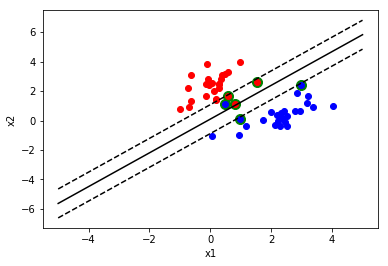

In [47]:
plot_margin(prob.Xstar[prob.Y==1], prob.Xstar[prob.Y==-1], priv_clf)

## Find Kernel Distance Between Each Point and Each Support Vector

In [48]:
frames = np.zeros((prob.num,len(priv_clf.support_vectors)))
for i in range(prob.num):
    for j in range(len(priv_clf.support_vectors)):
        frames[i][j] = prob.kernel((priv_clf.support_vectors[j]),prob.Xstar[i])

In [49]:
frames

array([[  3.02560899,   2.32063412,   5.17810451,   2.08901138,
          5.68173976,   0.7350813 ],
       [  4.70125748,   2.97603496,   7.12371449,   3.11807489,
          5.5976048 ,  -0.27059666],
       [  2.54237129,   1.81908733,   4.15941687,   1.72878454,
          4.10276677,   0.32403658],
       [  5.68909755,   4.15142497,   9.42592687,   3.88493525,
          9.59544996,   0.90641439],
       [  3.99633643,   2.68941863,   6.2892674 ,   2.68294993,
          5.57709158,   0.12802997],
       [  1.13693503,   0.49531653,   1.39422567,   0.70850283,
          0.20260328,  -0.56879892],
       [  3.13848807,   1.85185142,   4.55816538,   2.05418875,
          3.04485003,  -0.48325849],
       [  4.84456619,   3.47699781,   7.94152022,   3.29641846,
          7.87268864,   0.64139907],
       [  5.2437665 ,   3.7587136 ,   8.58889473,   3.56707533,
          8.49681615,   0.68349635],
       [  5.45287139,   3.94000713,   8.97737817,   3.71569604,
          8.99675701,   0.7

## Generate Pairs

In [50]:
training_pairs = np.zeros((prob.num,len(priv_clf.support_vectors)), dtype=object)
for i in range(prob.num):
    for j in range(len(priv_clf.support_vectors)):
        training_pairs[i][j] = [prob.X[i], frames[i][j]]

In [51]:
training_pairs = np.array(training_pairs)
training_pairs

array([[[array([-1.10001043, -0.07390296]), 3.0256089911154884],
        [array([-1.10001043, -0.07390296]), 2.3206341176992282],
        [array([-1.10001043, -0.07390296]), 5.1781045129111583],
        [array([-1.10001043, -0.07390296]), 2.0890113798368883],
        [array([-1.10001043, -0.07390296]), 5.6817397603109994],
        [array([-1.10001043, -0.07390296]), 0.73508130451580822]],
       [[array([-1.91899995,  0.1190407 ]), 4.7012574780068377],
        [array([-1.91899995,  0.1190407 ]), 2.9760349596271283],
        [array([-1.91899995,  0.1190407 ]), 7.1237144914487205],
        [array([-1.91899995,  0.1190407 ]), 3.1180748930711193],
        [array([-1.91899995,  0.1190407 ]), 5.5976048035203503],
        [array([-1.91899995,  0.1190407 ]), -0.27059666007480554]],
       [[array([-0.43994517,  0.40212075]), 2.5423712859180765],
        [array([-0.43994517,  0.40212075]), 1.8190873282298272],
        [array([-0.43994517,  0.40212075]), 4.1594168721810334],
        [array([-0.4

In [52]:
regr_pairs = np.zeros((len(priv_clf.support_vectors),prob.num), dtype=object)
for i in range(prob.num):
    for j in range(len(priv_clf.support_vectors)):
        regr_pairs[j][i] = training_pairs[i][j]

In [53]:
regr_pairs

array([[[array([-1.10001043, -0.07390296]), 3.0256089911154884],
        [array([-1.91899995,  0.1190407 ]), 4.7012574780068377],
        [array([-0.43994517,  0.40212075]), 2.5423712859180765],
        [array([-0.17245722,  1.3346431 ]), 5.6890975506077357],
        [array([-1.51064769,  2.1501167 ]), 3.9963364283091338],
        [array([ 1.21745923, -0.58399705]), 1.1369350289508846],
        [array([-1.37745175,  0.40310548]), 3.138488073124619],
        [array([-1.85209846,  0.67825505]), 4.8445661927213708],
        [array([-1.10773672, -1.39824116]), 5.2437664969798634],
        [array([ 2.52220778,  1.50079755]), 5.4528713905376494],
        [array([-0.03221829, -0.21914518]), 2.6695515241096479],
        [array([ 0.60067872,  1.59908965]), 7.0590563250019516],
        [array([-1.00070735,  2.06585586]), 2.3206341176992282],
        [array([-0.25383939,  1.25191101]), 3.8700254222932839],
        [array([-1.17325514,  1.50162667]), 3.3123170902439183],
        [array([ 1.2320447

## Find Regression Function Over Pairs Per Input

In [63]:
models = []
polyFit = []
for dataSet in regr_pairs:
    #poly = pf(degree=2)
    regr = lm.LinearRegression()
    xs = []
    ys = []
    for i in range(prob.num):
        xs.append(dataSet[i][0].flatten())
        ys.append(dataSet[i][1])
    xs = np.array(xs)
    ys = np.array(ys)
    #poly.fit(xs)
    #polyFit.append(poly)
    #x_ = poly.transform(xs)
    models.append(regr.fit(xs, ys))

In [64]:
def F(x):
    toReturn = []
    for i in range(len(models)):
        #x_ = polyFit[i].transform(x)
        toReturn.append(models[i].predict(x))
    toReturn = np.array(toReturn)
    return toReturn

In [65]:
print(F(prob.X[0].reshape(1,-1)).flatten())

[ 3.57148324  2.80089586  6.20248565  2.47840917  7.02270585  1.00583182]


## Construct New Triplets

We want to now construct new triplets so that instead of $(x_1, x^*_1, y_1), \cdots , (x_\ell, x^*_\ell, y_\ell)$ we have $(F(x_1), x^*_1, s^*_1), \cdots , (F(x_\ell), x^*_\ell, s^*_\ell)$, where $s^*_i$ is the sign of the prediction space $X^*$. 

In [72]:
new_xs = []
new_ys = []
for i in range(prob.num):
    new_xs.append(F(prob.X[i].reshape(1,-1)).flatten())
    new_ys.append(priv_clf.predict(prob.Xstar[i]))
new_x = np.array(new_xs)
new_y = np.array(new_ys)
new_prob = svm_problem()
new_prob.set_variables(new_x, prob.Xstar, new_y)

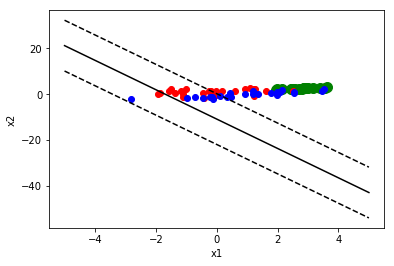

KT SVM


(None, None)

In [100]:
new_svm = SVM()
new_clf = new_svm.train(new_prob.X, new_prob)
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], new_clf), print("KT SVM")

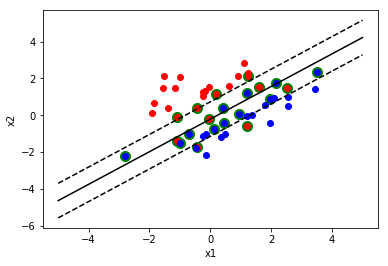

original SVM


(None, None)

In [68]:
svm = SVM()
svm_clf = svm.train(prob.X, prob)
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svm_clf), print("original SVM")

You're probably thinking that that looks terrible. Which it does, but it's not. See although we started off with $X$ as having 2-dimensions, it now has many. So, there's no way to plot it. So we have to see how well it performs.

So, let's put all this in a class, then try it out!

In [127]:
class KT():
    def train(self, prob: svm_problem):
        self.x = prob.X
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]
        
        svm = SVM()
        priv_clf = svm.train(prob.Xstar, prob)
        
        frames = np.zeros((prob.num,len(priv_clf.support_vectors)))
        for i in range(prob.num):
            for j in range(len(priv_clf.support_vectors)):
                frames[i][j] = prob.kernel((priv_clf.support_vectors[j]),prob.Xstar[i])
                
        training_pairs = np.zeros((prob.num,len(priv_clf.support_vectors)), dtype=object)
        for i in range(prob.num):
            for j in range(len(priv_clf.support_vectors)):
                training_pairs[i][j] = [prob.X[i], frames[i][j]]
        training_pairs = np.array(training_pairs)
        
        regr_pairs = np.zeros((len(priv_clf.support_vectors),prob.num), dtype=object)
        for i in range(prob.num):
            for j in range(len(priv_clf.support_vectors)):
                regr_pairs[j][i] = training_pairs[i][j]
                
        self.models = []
        self.polyFit = []
        for dataSet in regr_pairs:
            self.poly = pf(degree=2)
            self.regr = lm.LinearRegression()
            xs = []
            ys = []
            for i in range(prob.num):
                xs.append(dataSet[i][0].flatten())
                ys.append(dataSet[i][1])
            xs = np.array(xs)
            ys = np.array(ys)
            self.poly.fit(xs)
            self.polyFit.append(poly)
            x_ = poly.transform(xs)
            self.models.append(self.regr.fit(x_, ys))
            
        new_xs = []
        new_ys = []
        for i in range(prob.num):
            new_xs.append(self.F(prob.X[i].reshape(1,-1)).flatten())
            new_ys.append(priv_clf.predict(prob.Xstar[i]))
        new_x = np.array(new_xs)
        new_y = np.array(new_ys)
        new_prob = svm_problem()
        new_prob.set_variables(new_x, prob.Xstar, new_y)
            
        new_svm = SVM()
        self.clf = new_svm.train(new_prob.X, new_prob)
        self.support_vectors = self.clf.support_vectors
        self.w = self.clf.w
        self.b = self.clf.b
        print(self.models)
        
    def F(self, x):
        toReturn = []
        for i in range(len(self.models)):
            x_ = self.polyFit[i].transform(x)
            toReturn.append(self.models[i].predict(x_))
        toReturn = np.array(toReturn)
        return toReturn

    def predict(self, x):
        print(x)
        new_x = np.array(self.F(prob.X[i].reshape(1,-1)).flatten())
        print(new_x)
        return self.clf.predict(new_x.T)
        
        

In [128]:
kt = KT()
kt.train(prob)
kt.predict([2,100])

kt.train(prob)
kt.predict([-100,-100])

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)]
[2, 100]
[ 1.14237262  1.60801978  3.02657374  0.93733126  5.89931391  1.91914085]
[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=

-1.0

/Users/oliverthomas/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 50
  if __name__ == '__main__':


IndexError: index 2 is out of bounds for axis 1 with size 2